# PCOS Detection Model
dataset: https://www.kaggle.com/datasets/shreyasvedpathak/pcos-dataset


In [78]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
import warnings

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Data Analysis

In [79]:
df = pd.read_csv('PCOS_data.csv')

# Display the first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (541, 45)


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,10.48,2,5,7.0,0,0,1.99,1.99,7.95,3.68,2.16,36,30,0.83,0.68,2.07,45.16,17.1,0.57,92.0,0,0,0,0,0,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,11.70,2,5,11.0,1,0,60.80,1.99,6.73,1.09,6.17,38,32,0.84,3.16,1.53,20.09,61.3,0.97,92.0,0,0,0,0,0,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,11.80,2,5,10.0,1,0,494.08,494.08,5.54,0.88,6.30,40,36,0.90,2.54,6.63,10.52,49.7,0.36,84.0,0,0,0,1,1,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,12.00,2,5,4.0,0,0,1.99,1.99,8.06,2.36,3.42,42,36,0.86,16.41,1.22,36.90,33.4,0.36,76.0,0,0,0,0,0,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,10.00,2,5,1.0,1,0,801.45,801.45,3.98,0.90,4.42,37,30,0.81,3.57,2.26,30.09,43.8,0.38,84.0,0,0,0,1,0,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [80]:
# Get a list of all column names
print("Column names:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

Column names:
1. Sl. No
2. Patient File No.
3. PCOS (Y/N)
4.  Age (yrs)
5. Weight (Kg)
6. Height(Cm) 
7. BMI
8. Blood Group
9. Pulse rate(bpm) 
10. RR (breaths/min)
11. Hb(g/dl)
12. Cycle(R/I)
13. Cycle length(days)
14. Marraige Status (Yrs)
15. Pregnant(Y/N)
16. No. of abortions
17.   I   beta-HCG(mIU/mL)
18. II    beta-HCG(mIU/mL)
19. FSH(mIU/mL)
20. LH(mIU/mL)
21. FSH/LH
22. Hip(inch)
23. Waist(inch)
24. Waist:Hip Ratio
25. TSH (mIU/L)
26. AMH(ng/mL)
27. PRL(ng/mL)
28. Vit D3 (ng/mL)
29. PRG(ng/mL)
30. RBS(mg/dl)
31. Weight gain(Y/N)
32. hair growth(Y/N)
33. Skin darkening (Y/N)
34. Hair loss(Y/N)
35. Pimples(Y/N)
36. Fast food (Y/N)
37. Reg.Exercise(Y/N)
38. BP _Systolic (mmHg)
39. BP _Diastolic (mmHg)
40. Follicle No. (L)
41. Follicle No. (R)
42. Avg. F size (L) (mm)
43. Avg. F size (R) (mm)
44. Endometrium (mm)
45. Unnamed: 44


Columns with missing values:
                       Missing Values  Percentage
Unnamed: 44                       539   99.630314
Marraige Status (Yrs)               1    0.184843
Fast food (Y/N)                     1    0.184843


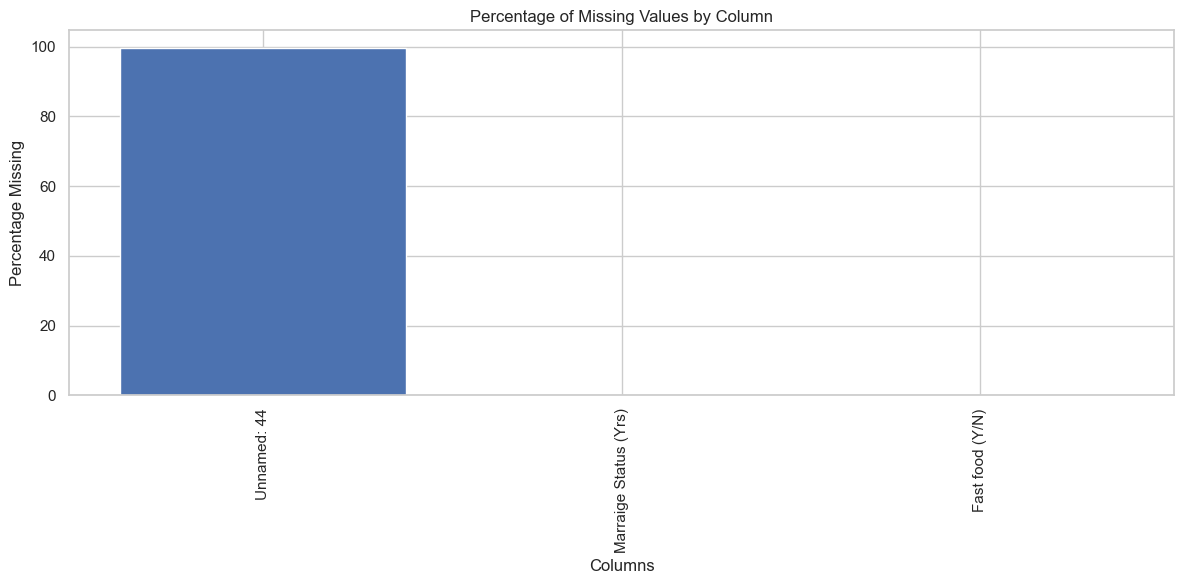

In [81]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Display columns with missing values
print("Columns with missing values:")
missing_with_values = missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
if not missing_with_values.empty:
    print(missing_with_values)
else:
    print("No missing values found in the dataset.")

# Visualize missing values
if not missing_with_values.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(missing_with_values.index, missing_with_values['Percentage'])
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl. No,541.0,271.000000,156.317519,1.000,136.00,271.00,406.00,541.00
Patient File No.,541.0,271.000000,156.317519,1.000,136.00,271.00,406.00,541.00
PCOS (Y/N),541.0,0.327172,0.469615,0.000,0.00,0.00,1.00,1.00
Age (yrs),541.0,31.430684,5.411006,20.000,28.00,31.00,35.00,48.00
Weight (Kg),541.0,59.637153,11.028287,31.000,52.00,59.00,65.00,108.00
Height(Cm),541.0,156.484835,6.033545,137.000,152.00,156.00,160.00,180.00
BMI,541.0,24.307579,4.055129,12.400,21.60,24.20,26.60,38.90
Blood Group,541.0,13.802218,1.840812,11.000,13.00,14.00,15.00,18.00
Pulse rate(bpm),541.0,73.247689,4.430285,13.000,72.00,72.00,74.00,82.00
RR (breaths/min),541.0,19.243993,1.688629,16.000,18.00,18.00,20.00,28.00


Target Variable Distribution:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

Percentage:
PCOS (Y/N)
0    67.28281
1    32.71719
Name: proportion, dtype: float64


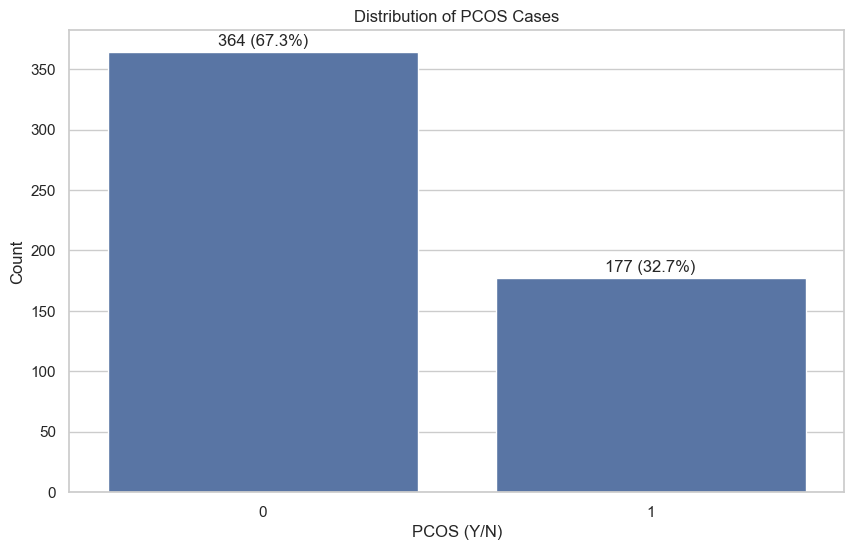

In [83]:
# Analyze the target variable 'PCOS (Y/N)'
if 'PCOS (Y/N)' in df.columns:
    target_counts = df['PCOS (Y/N)'].value_counts()
    target_percentage = df['PCOS (Y/N)'].value_counts(normalize=True) * 100
    
    print("Target Variable Distribution:")
    print(target_counts)
    print("\nPercentage:")
    print(target_percentage)
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='PCOS (Y/N)', data=df)
    plt.title('Distribution of PCOS Cases')
    plt.xlabel('PCOS (Y/N)')
    plt.ylabel('Count')
    
    # Add count labels on top of bars
    for i, count in enumerate(target_counts):
        ax.text(i, count + 5, f"{count} ({target_percentage.iloc[i]:.1f}%)", ha='center')
    
    plt.show()
else:
    print("Target variable 'PCOS (Y/N)' not found in the dataset.")

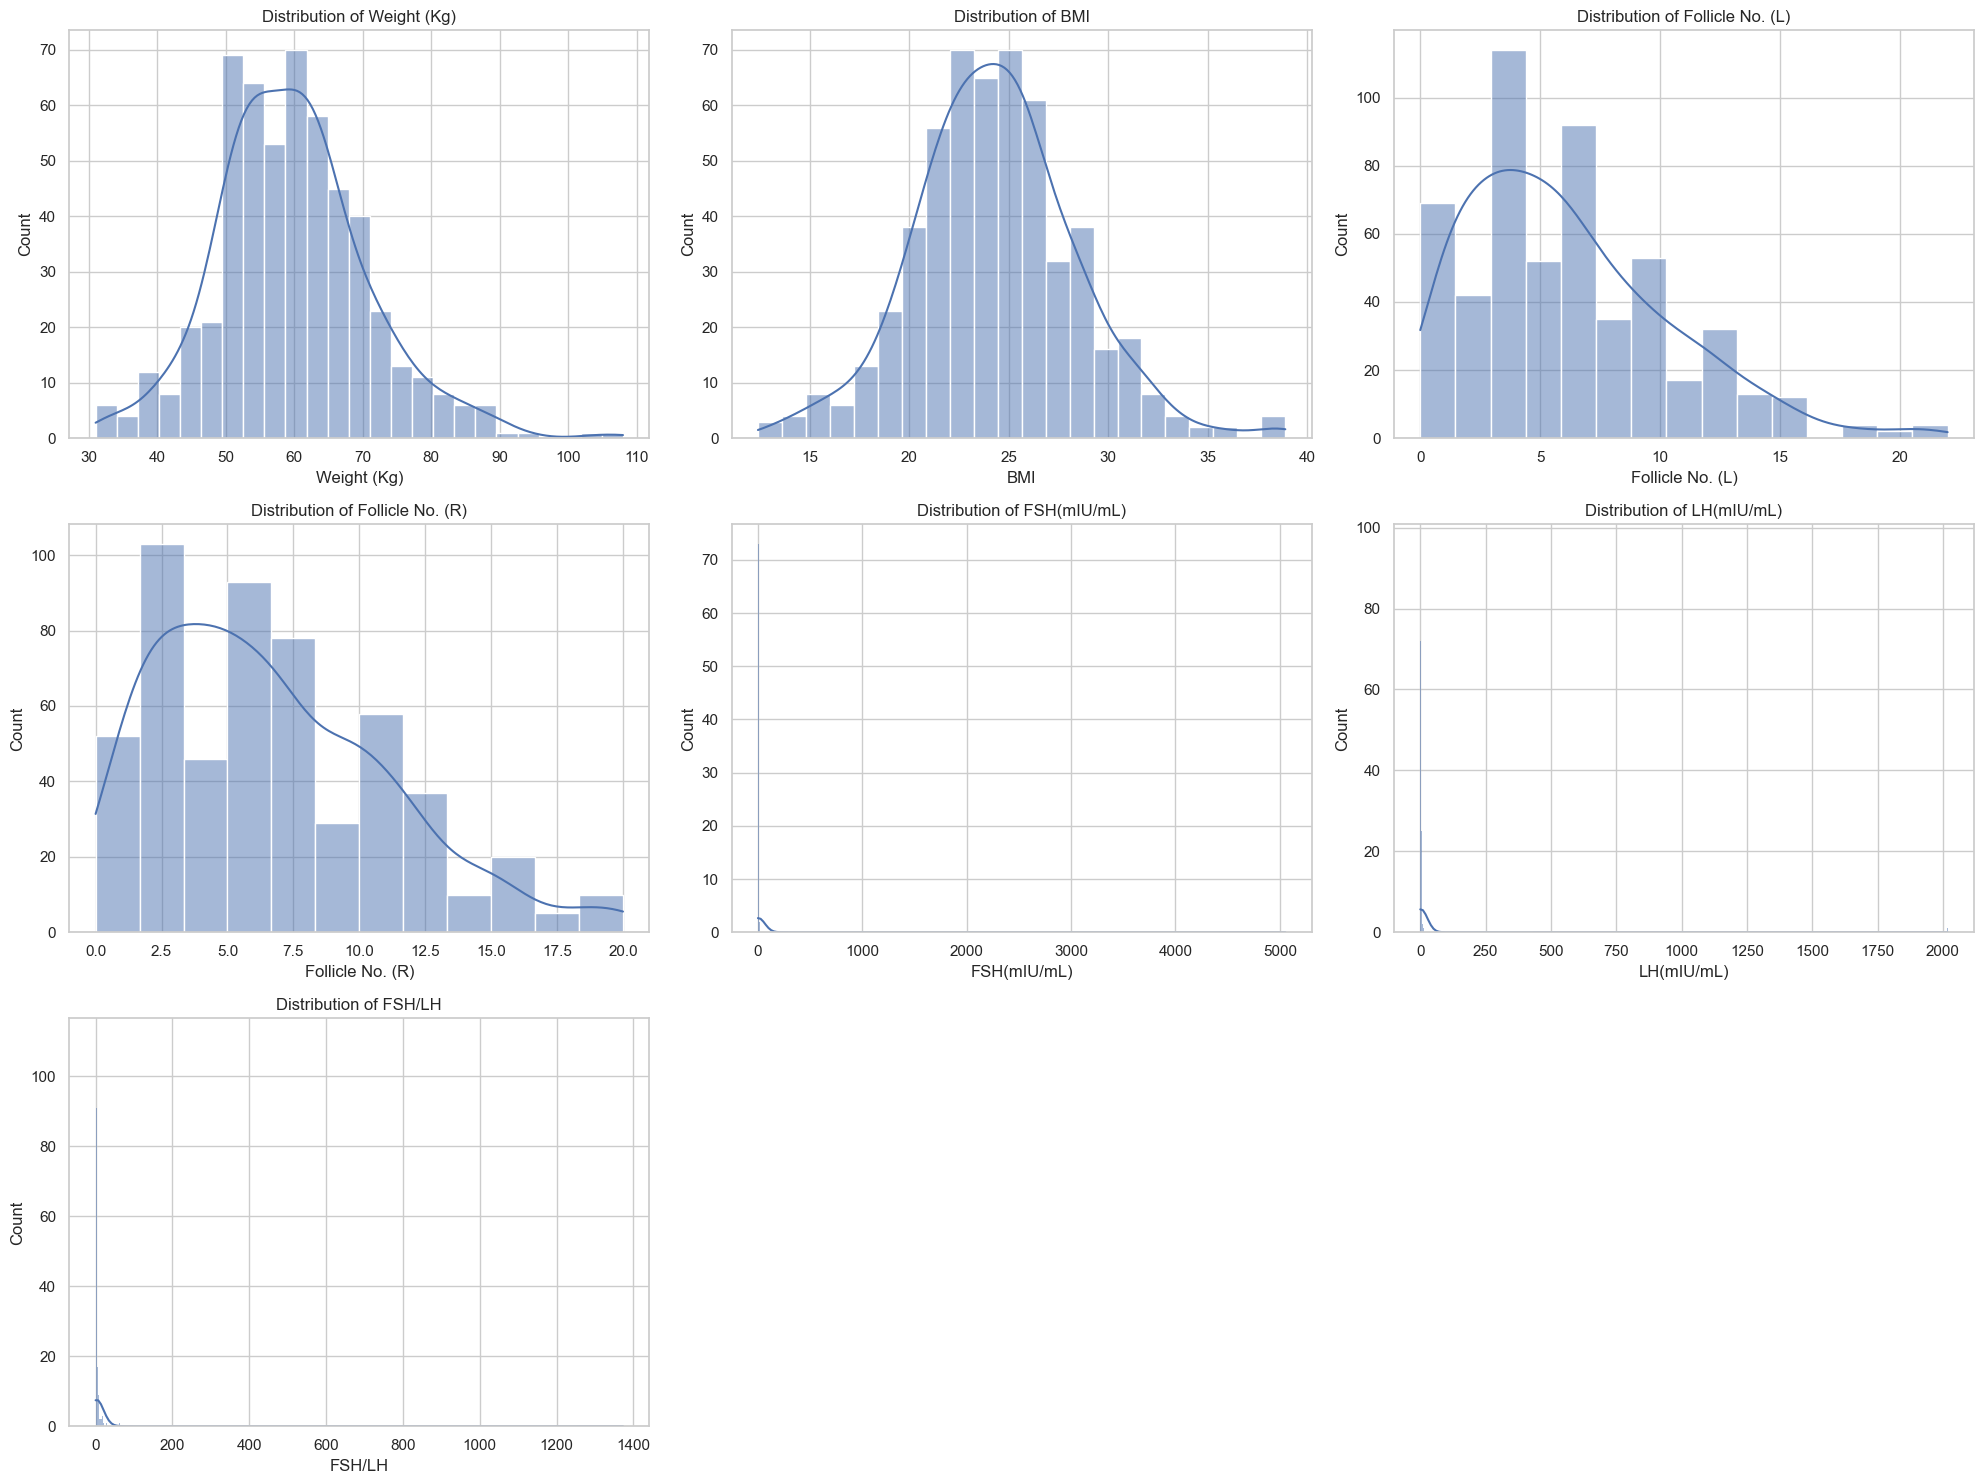

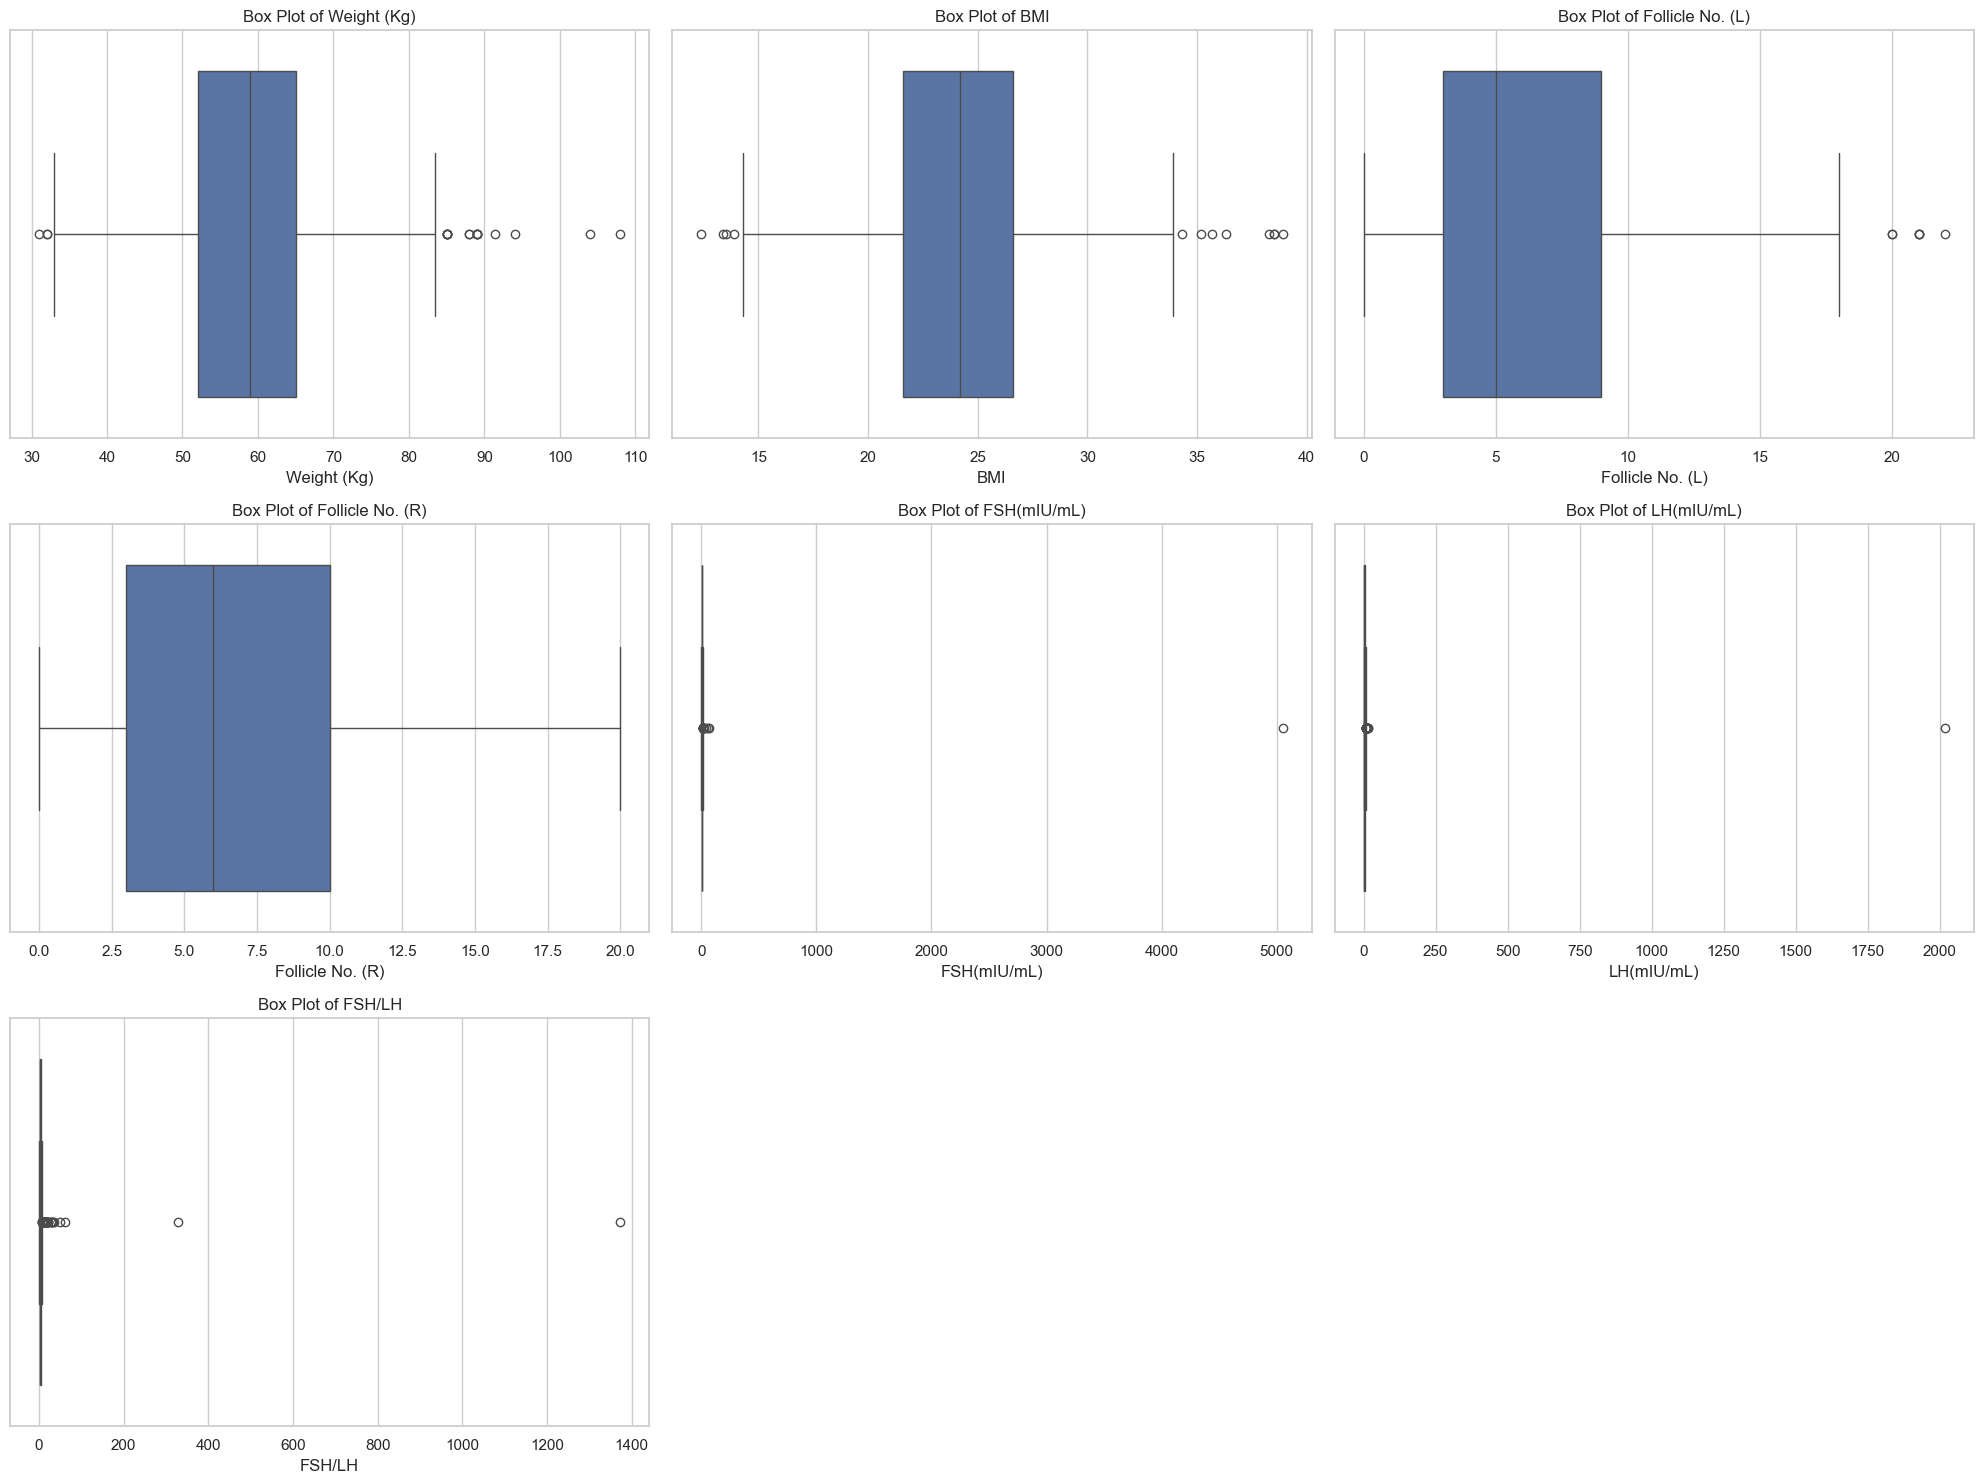

In [84]:
# Analyze distribution of key numerical features
key_numerical_features = [
    'Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 
    'Follicle No. (L)', 'Follicle No. (R)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH'
]

# Check which features are available in the dataset
available_features = [feature for feature in key_numerical_features if feature in df.columns]

if available_features:
    # Create histograms for key numerical features
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(available_features):
        plt.subplot(3, 3, i+1)
        sns.histplot(data=df, x=feature, kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()
    
    # Create box plots to check for outliers
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(available_features):
        plt.subplot(3, 3, i+1)
        sns.boxplot(x=df[feature])
        plt.title(f'Box Plot of {feature}')
    plt.tight_layout()
    plt.show()
else:
    print("None of the key numerical features were found in the dataset.")

In [96]:
# Function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers.count(), lower_bound, upper_bound

# Check for outliers in key numerical features
if available_features:
    print("Outlier Analysis:")
    print("-" * 60)
    print(f"{'Feature':<25} {'Outliers':<10} {'Lower Bound':<15} {'Upper Bound':<15}")
    print("-" * 60)
    
    for feature in available_features:
        if df[feature].dtype in ['int64', 'float64']:
            outlier_count, lower, upper = detect_outliers(df, feature)
            print(f"{feature:<25} {outlier_count:<10} {lower:<15.2f} {upper:<15.2f}")
else:
    print("No numerical features available for outlier analysis.")

Outlier Analysis:
------------------------------------------------------------
Feature                   Outliers   Lower Bound     Upper Bound    
------------------------------------------------------------
Weight (Kg)               18         32.50           84.50          
BMI                       12         14.10           34.10          
Follicle No. (L)          6          -6.00           18.00          
Follicle No. (R)          0          -7.50           20.50          
FSH(mIU/mL)               12         -1.37           11.08          
LH(mIU/mL)                24         -2.97           7.67           
FSH/LH                    48         -2.39           7.77           


# 2. Data Cleaning

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [86]:
# Basic cleaning
df_clean = df.copy()

# Remove unnecessary columns
if '' in df_clean.columns:
    df_clean = df_clean.drop('', axis=1)
if 'Sl. No' in df_clean.columns:
    df_clean = df_clean.drop('Sl. No', axis=1)

# Remove duplicate rows if any
df_clean = df_clean.drop_duplicates()

# Check for missing values
missing_values = df_clean.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])

# Handle missing values
# For numerical columns, impute with median
for col in df_clean.select_dtypes(include=['int64', 'float64']).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        
# For categorical columns, impute with mode
for col in df_clean.select_dtypes(include=['object']).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Verify no missing values remain
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df_clean['PCOS (Y/N)'].value_counts())
print(f"Percentage of PCOS cases: {df_clean['PCOS (Y/N)'].mean() * 100:.2f}%")


Columns with missing values:
Marraige Status (Yrs)      1
Fast food (Y/N)            1
Unnamed: 44              539
dtype: int64

Remaining missing values: 0

Target Variable Distribution:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64
Percentage of PCOS cases: 32.72%


## 3. Feature Selection and Engineering


In [87]:
# Create a copy for feature engineering
df_fe = df_clean.copy()

# 1. Create Total_Follicle_Count
df_fe['Total_Follicle_Count'] = df_fe['Follicle No. (L)'] + df_fe['Follicle No. (R)']

# 2. Create LH_FSH_Ratio
# Avoid division by zero by replacing zeros with a small value
df_fe['LH_FSH_Ratio'] = df_fe['LH(mIU/mL)'] / df_fe['FSH(mIU/mL)'].replace(0, 0.001)

# 3. Create Symptom_Count
symptom_cols = ['Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)']
df_fe['Symptom_Count'] = df_fe[symptom_cols].sum(axis=1)

# 4. Create Lifestyle_Score (higher is worse)
df_fe['Lifestyle_Score'] = df_fe['Fast food (Y/N)'] - df_fe['Reg.Exercise(Y/N)'] + 1  # +1 to avoid negative values

# Handle Cycle(R/I) if it's not numeric
if df_fe['Cycle(R/I)'].dtype == 'object':
    # Convert R/I to 1/0 (Regular=1, Irregular=0)
    df_fe['Cycle(R/I)'] = df_fe['Cycle(R/I)'].map(lambda x: 1 if x == 'R' else 0)

# Display the engineered features
print("Engineered features:")
print(df_fe[['Total_Follicle_Count', 'LH_FSH_Ratio', 'Symptom_Count', 'Lifestyle_Score']].describe())

# Check if all selected features are available
selected_features = [
    'Weight (Kg)', 'Lifestyle_Score', 'Cycle(R/I)', 'BMI', 'LH_FSH_Ratio',
    'Weight gain(Y/N)', 'hair growth(Y/N)', 'Follicle No. (L)', 'Age (yrs)',
    'Follicle No. (R)', 'Symptom_Count', 'Hip(inch)', 'Skin darkening (Y/N)',
    'Total_Follicle_Count', 'Cycle length(days)'
]

missing_features = [feature for feature in selected_features if feature not in df_fe.columns]
if missing_features:
    print(f"\nWarning: The following selected features are missing: {missing_features}")
else:
    print("\nAll selected features are available in the dataset.")

Engineered features:
       Total_Follicle_Count  LH_FSH_Ratio  Symptom_Count  Lifestyle_Score
count            541.000000    541.000000     541.000000       541.000000
mean              12.770795      1.413489       1.900185         1.268022
std                8.220748     20.018477       1.499759         0.638483
min                1.000000      0.000728       0.000000         0.000000
25%                6.000000      0.252577       1.000000         1.000000
50%               12.000000      0.460993       2.000000         1.000000
75%               18.000000      0.706093       3.000000         2.000000
max               41.000000    466.050808       5.000000         2.000000



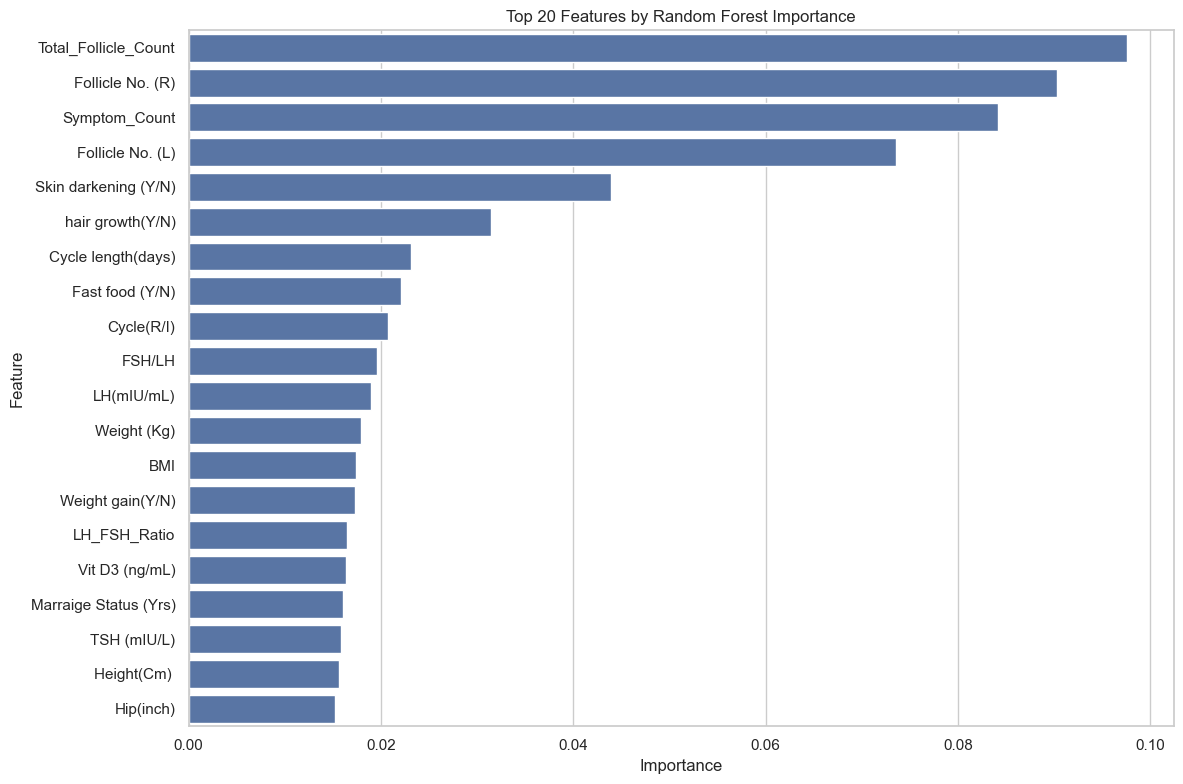

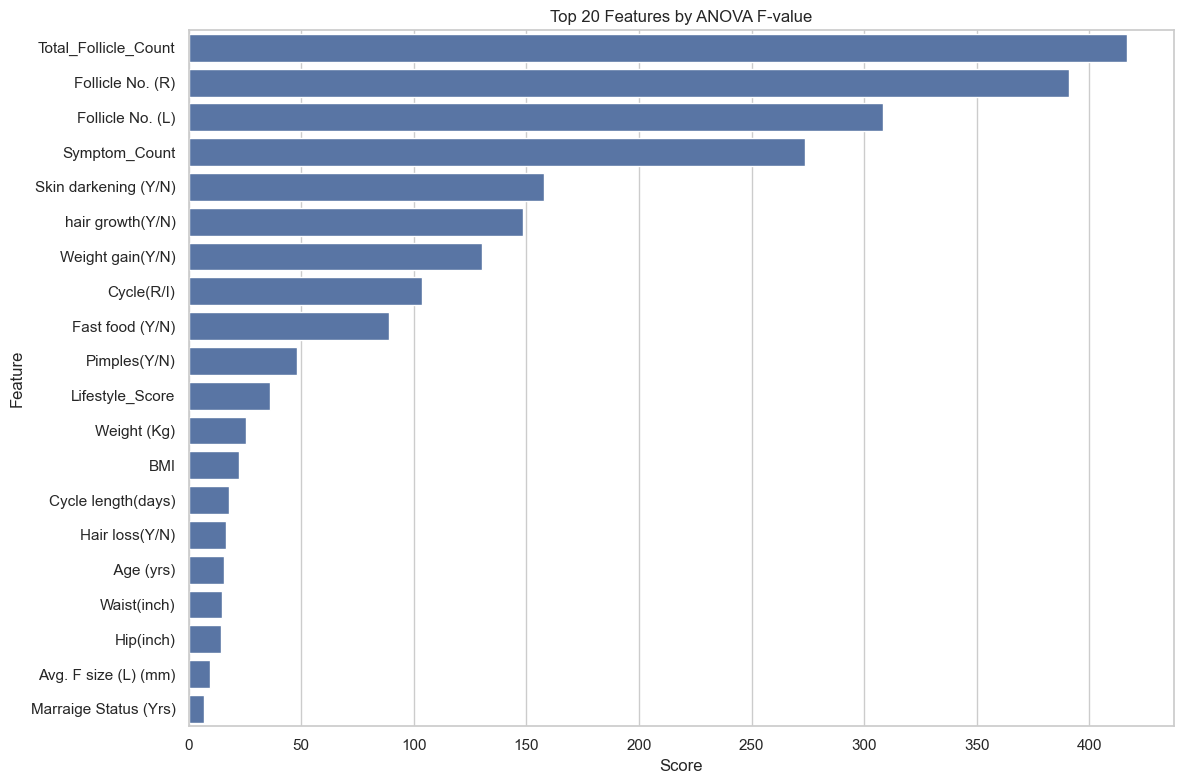

Number of common features: 14

Common features:
- Skin darkening (Y/N)
- Cycle length(days)
- Weight gain(Y/N)
- BMI
- Follicle No. (R)
- hair growth(Y/N)
- Fast food (Y/N)
- Cycle(R/I)
- Symptom_Count
- Marraige Status (Yrs)
- Follicle No. (L)
- Hip(inch)
- Weight (Kg)
- Total_Follicle_Count


In [88]:
# Prepare data for feature selection
# First, let's drop non-feature columns
non_feature_cols = ['Patient File No.']
X = df_fe.drop(['PCOS (Y/N)'] + non_feature_cols, axis=1)
y = df_fe['PCOS (Y/N)']

# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Method 1: Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

# Method 2: Statistical feature selection using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_encoded, y)

# Get selected feature names
selected_features_mask = selector.get_support()
selected_features = X_encoded.columns[selected_features_mask]

# Get scores
feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

# Plot feature scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(20))
plt.title('Top 20 Features by ANOVA F-value')
plt.tight_layout()
plt.show()

# Get top 20 features from each method
rf_top_features = feature_importances.head(20)['Feature'].tolist()
anova_top_features = feature_scores.head(20)['Feature'].tolist()

# Find features that appear in both methods
common_features = list(set(rf_top_features).intersection(set(anova_top_features)))

print(f"Number of common features: {len(common_features)}")
print("\nCommon features:")
for feature in common_features:
    print(f"- {feature}")

## 4. Prepare Data for Modeling

Now we'll prepare the data using only the selected features.

In [89]:
df_fe.columns = df_fe.columns.str.strip()
selected_features = [col.strip() for col in selected_features]

X = df_fe[selected_features]
y = df_fe['PCOS (Y/N)']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {categorical_cols}")
print(f"Number of numerical features: {len(numerical_cols)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Create preprocessing pipelines
# For numerical features: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training set shape: {X_train_processed.shape}")
print(f"Processed testing set shape: {X_test_processed.shape}")

Feature matrix shape: (541, 20)
Target vector shape: (541,)

Categorical features: []
Number of numerical features: 20

Training set shape: (432, 20)
Testing set shape: (109, 20)

Processed training set shape: (432, 20)
Processed testing set shape: (109, 20)


## 5. Model Training and Evaluation

Let's train multiple models and evaluate their performance.


Training Logistic Regression...
  Accuracy: 0.9266
  CV Score: 0.9075 ± 0.0407

Training Random Forest...
  Accuracy: 0.9358
  CV Score: 0.8913 ± 0.0514

Training Gradient Boosting...
  Accuracy: 0.9266
  CV Score: 0.8866 ± 0.0443

Training SVM...
  Accuracy: 0.9266
  CV Score: 0.8842 ± 0.0458

Training KNN...
  Accuracy: 0.8991
  CV Score: 0.8727 ± 0.0479

Training Decision Tree...
  Accuracy: 0.8532
  CV Score: 0.8682 ± 0.0387

Model Comparison:
                 Model  Accuracy   CV Mean    CV Std
0  Logistic Regression  0.926606  0.907458  0.040677
1        Random Forest  0.935780  0.891312  0.051433
2    Gradient Boosting  0.926606  0.886581  0.044290
3                  SVM  0.926606  0.884229  0.045830
4                  KNN  0.899083  0.872735  0.047870
5        Decision Tree  0.853211  0.868190  0.038744


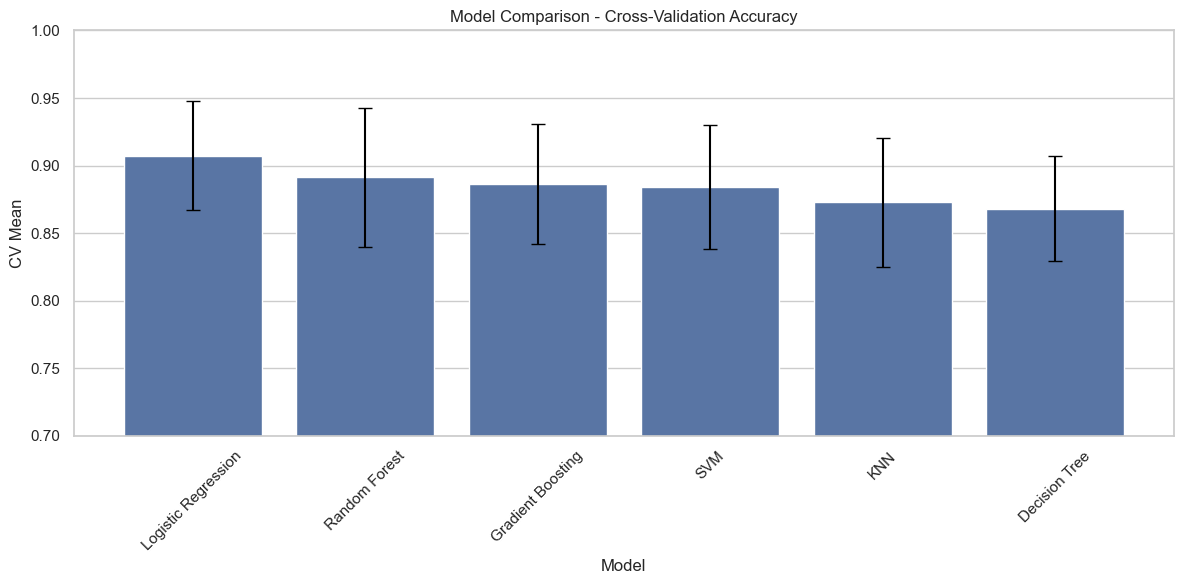


Best model: Logistic Regression
Accuracy: 0.9266
CV Score: 0.9075 ± 0.0407


In [90]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Score: {cv_mean:.4f} ± {cv_std:.4f}")

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'CV Mean': [results[model]['cv_mean'] for model in results],
    'CV Std': [results[model]['cv_std'] for model in results]
})

# Sort by CV Mean
results_df = results_df.sort_values('CV Mean', ascending=False)

# Display results
print("\nModel Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='CV Mean', data=results_df)
plt.errorbar(x=range(len(results_df)), y=results_df['CV Mean'], yerr=results_df['CV Std'], fmt='none', c='black', capsize=5)
plt.title('Model Comparison - Cross-Validation Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# Select the best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_y_pred = results[best_model_name]['y_pred']

print(f"\nBest model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"CV Score: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

## 6. Detailed Evaluation of the Best Model


Detailed evaluation of the best model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        73
           1       0.91      0.86      0.89        36

    accuracy                           0.93       109
   macro avg       0.92      0.91      0.92       109
weighted avg       0.93      0.93      0.93       109



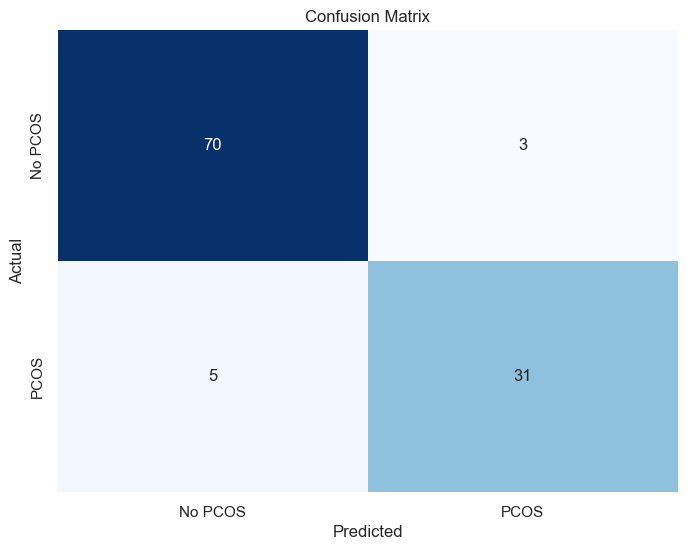


Detailed Metrics:
Sensitivity (Recall): 0.8611
Specificity: 0.9589
Precision: 0.9118
F1 Score: 0.8857
Accuracy: 0.9266


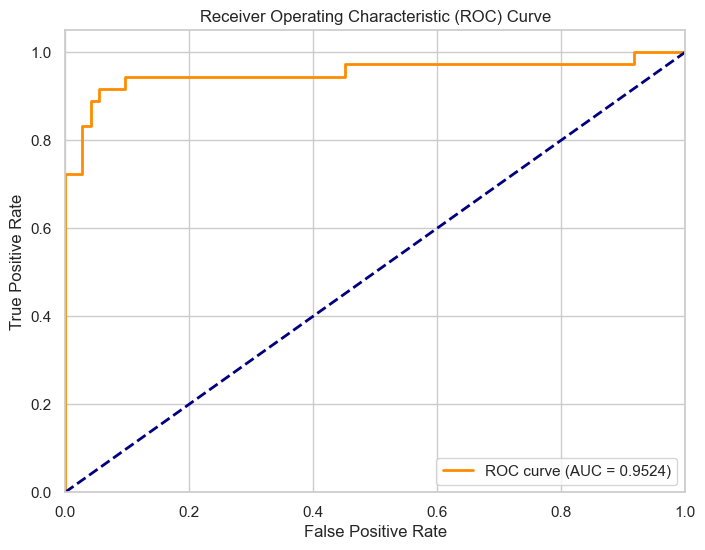


AUC: 0.9524


In [91]:
# Detailed evaluation of the best model
print(f"\nDetailed evaluation of the best model: {best_model_name}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, best_y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No PCOS', 'PCOS'],
            yticklabels=['No PCOS', 'PCOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Precision
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)  # F1 Score

print("\nDetailed Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

# ROC curve and AUC
if hasattr(best_model, 'predict_proba'):
    y_prob = best_model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print(f"\nAUC: {roc_auc:.4f}")
else:
    print("\nThis model doesn't support probability predictions. Skipping ROC curve and AUC calculation.")

## 7. Feature Importance Analysis

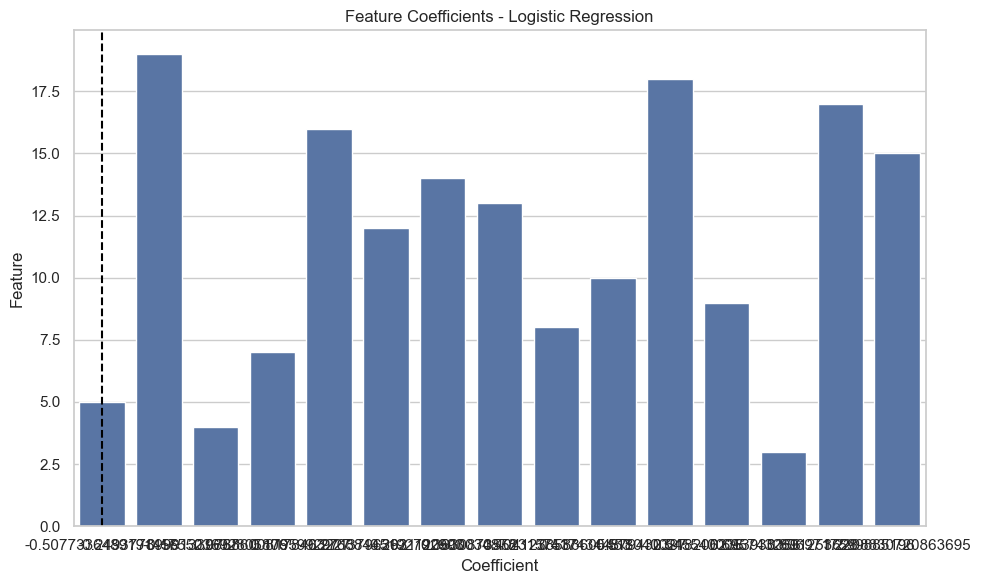

Top 10 most important features (by index):
    Feature  Coefficient  Abs_Coefficient
15       15     1.220883         1.220883
17       17     0.806972         0.806972
3         3     0.695743         0.695743
9         9     0.545540         0.545540
18       18     0.518040         0.518040
5         5    -0.507734         0.507734
10       10     0.417434         0.417434
8         8     0.404124         0.404124
13       13     0.363087         0.363087
14       14     0.292112         0.292112


In [92]:
# Analyze feature importance for the best model (if available)
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models like Random Forest, Gradient Boosting, etc.
    importances = best_model.feature_importances_
    
    # Get feature names after preprocessing
    # This is a bit tricky with the ColumnTransformer
    # For simplicity, we'll just use indices
    feature_indices = range(len(importances))
    
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_indices,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features (by index):")
    print(importance_df.head(10))
    
elif hasattr(best_model, 'coef_'):
    # For linear models like Logistic Regression
    coefficients = best_model.coef_[0]
    
    # Get feature names after preprocessing
    # For simplicity, we'll just use indices
    feature_indices = range(len(coefficients))
    
    # Create a DataFrame for visualization
    coef_df = pd.DataFrame({
        'Feature': feature_indices,
        'Coefficient': coefficients
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features (by index):")
    print(coef_df.head(10))
    
else:
    print("This model doesn't provide feature importances or coefficients.")

## 8. Save the Model

In [93]:
# Create a pipeline that includes preprocessing and the model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Save the full pipeline
with open('pcos_model.pkl', 'wb') as f:
    pickle.dump(full_pipeline, f)

# Also save the list of selected features
with open('pcos_selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

print("Model saved as 'pcos_model.pkl'")
print("Selected features saved as 'pcos_selected_features.pkl'")


Model saved as 'pcos_model.pkl'
Selected features saved as 'pcos_selected_features.pkl'
